## BERT model for Multi Class Classification

In [ ]:
!pip install transformers
!pip install scikit-plot

     |████████████████████████████████| 2.5MB 15.4MB/s 
     |████████████████████████████████| 901kB 32.0MB/s 
     |████████████████████████████████| 3.3MB 37.7MB/s 


In [ ]:
# import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt
from collections import defaultdict

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score

from keras.preprocessing.sequence import pad_sequences

from scikitplot.metrics import plot_confusion_matrix, plot_roc

import transformers
from transformers import BertModel, BertTokenizerFast
from transformers import AdamW, AdamWeightDecay, get_linear_schedule_with_warmup

import torch
from torch import optim, nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F 

%config InlineBackend.figure_format='retina'
%matplotlib inline

sns.set(style='whitegrid')

import warnings
warnings.filterwarnings('ignore')

seed=123
np.random.seed(seed)
torch.manual_seed(seed)

In [ ]:
device=torch.device('cuda:0')
torch.cuda.get_device_name(0)

'Tesla K80'

## Read the datasets

In [ ]:
df=pd.read_excel('/content/Ambev-3Produtos_MultiClass-Treino.xlsx')

In [ ]:
print(f'Shape of the dataset: {df.shape}')

Shape of the dataset: (3382, 11)


In [ ]:
df.head()

,Inbound Message,Sender Profile Image Url,Created Time,Permalink,snTypeColumn,Marca (I) (Message),Sentiment,Nome Iniciativa (I) (Message),Assunto (I) (Message),Detalhe (I) (Message),Label
0,todo mundo comprou aquela beats zodiac hj kkkk...,https://pbs.twimg.com/profile_images/127952075...,2021-01-01 00:00:18,https://twitter.com/lespapillonz/status/134484...,Twitter,Beats,Negative,Zodíaco,Produto,Elogios ou queixas de líquido,0
1,Nossa a beats zodiac é horrível.,https://pbs.twimg.com/profile_images/137710322...,2021-01-01 00:30:18,https://twitter.com/axllive/status/13448483965...,Twitter,Beats,Negative,Zodíaco,Produto,Elogios ou queixas de líquido,0
2,ANITTAAA VC ME PROMETEU QUE A BEATS ZODIAC ERA...,https://pbs.twimg.com/profile_images/136368397...,2021-01-01 00:30:26,https://twitter.com/Klausitox/status/134484842...,Twitter,Beats,Negative,Zodíaco,Produto,Elogios ou queixas de líquido,0
3,Essa Skol Beats dos signos de água só pode ser...,https://pbs.twimg.com/profile_images/134950002...,2021-01-01 00:37:54,https://twitter.com/igorwernera/status/1344850...,Twitter,Beats,Negative,Zodíaco,Produto,Elogios ou queixas de líquido,0
4,Essa Skol Beats dos signos de água só pode ser...,https://pbs.twimg.com/profile_images/134950002...,2021-01-01 00:37:54,https://twitter.com/igorwernera/status/1344850...,Twitter,Skol,Negative,Zodíaco,Produto,Elogios ou queixas de líquido,0


In [ ]:
df.columns

Index(['Inbound Message', 'Sender Profile Image Url', 'Created Time',
       'Permalink', 'snTypeColumn', 'Marca (I) (Message)', 'Sentiment',
       'Nome Iniciativa (I) (Message)', 'Assunto (I) (Message)',
       'Detalhe (I) (Message)', 'Label'],
      dtype='object')

In [ ]:
# Unique classes in target variable (Label)
df['Label'].unique()

array([0, 1, 3, 2, 4])

In [ ]:
df['Inbound Message'].head()

0    todo mundo comprou aquela beats zodiac hj kkkk...
1                     Nossa a beats zodiac é horrível.
2    ANITTAAA VC ME PROMETEU QUE A BEATS ZODIAC ERA...
3    Essa Skol Beats dos signos de água só pode ser...
4    Essa Skol Beats dos signos de água só pode ser...
Name: Inbound Message, dtype: object

Let's check missing values if there are any.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3382 entries, 0 to 3381
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   Inbound Message                3380 non-null   object
 1   Sender Profile Image Url       3210 non-null   object
 2   Created Time                   3382 non-null   object
 3   Permalink                      3381 non-null   object
 4   snTypeColumn                   3382 non-null   object
 5   Marca (I) (Message)            3382 non-null   object
 6   Sentiment                      3382 non-null   object
 7   Nome Iniciativa (I) (Message)  3382 non-null   object
 8   Assunto (I) (Message)          3382 non-null   object
 9   Detalhe (I) (Message)          3382 non-null   object
 10  Label                          3382 non-null   int64 
dtypes: int64(1), object(10)
memory usage: 290.8+ KB


In [ ]:
# Convert object type to string
df['Inbound Message'] = df['Inbound Message'].astype('str')

In [ ]:
def preprocessing(df):
    # Replace @,# etc by ' '
    df['Inbound Message']=df['Inbound Message'].apply(lambda x: re.sub(r'[@#]',' ', str(x)))
    #Excluding html tags
    df['Inbound Message']=df['Inbound Message'].apply(lambda x: re.sub(r'<[^<>]+>]',' ', str(x)))
    # Replace https links by ' '
    df['Inbound Message']=df['Inbound Message'].apply(lambda x: re.sub(r'http://\S+|https://\S+',' ',str(x)))
    return df

In [ ]:
# Apply preprocessing function
df=preprocessing(df)

In [ ]:
df

,Inbound Message,Sender Profile Image Url,Created Time,Permalink,snTypeColumn,Marca (I) (Message),Sentiment,Nome Iniciativa (I) (Message),Assunto (I) (Message),Detalhe (I) (Message),Label
0,todo mundo comprou aquela beats zodiac hj kkkk...,https://pbs.twimg.com/profile_images/127952075...,2021-01-01 00:00:18,https://twitter.com/lespapillonz/status/134484...,Twitter,Beats,Negative,Zodíaco,Produto,Elogios ou queixas de líquido,0
1,Nossa a beats zodiac é horrível.,https://pbs.twimg.com/profile_images/137710322...,2021-01-01 00:30:18,https://twitter.com/axllive/status/13448483965...,Twitter,Beats,Negative,Zodíaco,Produto,Elogios ou queixas de líquido,0
2,ANITTAAA VC ME PROMETEU QUE A BEATS ZODIAC ERA...,https://pbs.twimg.com/profile_images/136368397...,2021-01-01 00:30:26,https://twitter.com/Klausitox/status/134484842...,Twitter,Beats,Negative,Zodíaco,Produto,Elogios ou queixas de líquido,0
3,Essa Skol Beats dos signos de água só pode ser...,https://pbs.twimg.com/profile_images/134950002...,2021-01-01 00:37:54,https://twitter.com/igorwernera/status/1344850...,Twitter,Beats,Negative,Zodíaco,Produto,Elogios ou queixas de líquido,0
4,Essa Skol Beats dos signos de água só pode ser...,https://pbs.twimg.com/profile_images/134950002...,2021-01-01 00:37:54,https://twitter.com/igorwernera/status/1344850...,Twitter,Skol,Negative,Zodíaco,Produto,Elogios ou queixas de líquido,0
...,...,...,...,...,...,...,...,...,...,...,...
3377,Pra mim nenhuma cerveja supera a Heineken 🥴,https://pbs.twimg.com/profile_images/135748511...,2021-03-14 20:56:14,https://twitter.com/Kethele_Santos/status/1371...,Twitter,Heineken,Positive,Marca,Produto,Comparação com concorrentes,4
3378,laviedpaola não amiga kkkkk naquela época era...,https://pbs.twimg.com/profile_images/137340814...,2021-03-14 21:12:26,https://twitter.com/elenocas/status/1371252917...,Twitter,Catuaba,Positive,Marca,Produto,Comparação com concorrentes,4
3379,guaraná antártica sempre vai ser melhor q coca,https://pbs.twimg.com/profile_images/138000939...,2021-03-14 21:46:07,https://twitter.com/Azkadelliaa/status/1371261...,Twitter,Guaraná,Positive,Marca,Produto,Comparação com concorrentes,4
3380,"coe Flavinho é pra lá de mt engraçado, disse q...",https://pbs.twimg.com/profile_images/138926710...,2021-03-14 22:01:31,https://twitter.com/nielzinho33/status/1371265...,Twitter,Skol,Positive,Marca,Produto,Comparação com concorrentes,4


In [ ]:
def replace(df):
  df=df.replace(regex={r'Ã£': 'ã','¢':'ó','ƒ':'â','Ã§':'ç','Ã³':'ó','“':'ô','ä':'õ','r pida':'rápida','ecess rio':'ecessário','Ã¡':'á',
                     'Ãª':'ê','Ã­':'í'})
  df['Inbound Message'] = df['Inbound Message'].str.replace(r'\n\n',' ', regex=True)
  df['Inbound Message'] = df['Inbound Message'].str.replace(r'\n',' ', regex = True)
  return df

In [ ]:
# Apply replace function
df= replace(df)

In [ ]:
df.head()

,Inbound Message,Sender Profile Image Url,Created Time,Permalink,snTypeColumn,Marca (I) (Message),Sentiment,Nome Iniciativa (I) (Message),Assunto (I) (Message),Detalhe (I) (Message),Label
0,todo mundo comprou aquela beats zodiac hj kkkk...,https://pbs.twimg.com/profile_images/127952075...,2021-01-01 00:00:18,https://twitter.com/lespapillonz/status/134484...,Twitter,Beats,Negative,Zodíaco,Produto,Elogios ou queixas de líquido,0
1,Nossa a beats zodiac é horrível.,https://pbs.twimg.com/profile_images/137710322...,2021-01-01 00:30:18,https://twitter.com/axllive/status/13448483965...,Twitter,Beats,Negative,Zodíaco,Produto,Elogios ou queixas de líquido,0
2,ANITTAAA VC ME PROMETEU QUE A BEATS ZODIAC ERA...,https://pbs.twimg.com/profile_images/136368397...,2021-01-01 00:30:26,https://twitter.com/Klausitox/status/134484842...,Twitter,Beats,Negative,Zodíaco,Produto,Elogios ou queixas de líquido,0
3,Essa Skol Beats dos signos de água só pode ser...,https://pbs.twimg.com/profile_images/134950002...,2021-01-01 00:37:54,https://twitter.com/igorwernera/status/1344850...,Twitter,Beats,Negative,Zodíaco,Produto,Elogios ou queixas de líquido,0
4,Essa Skol Beats dos signos de água só pode ser...,https://pbs.twimg.com/profile_images/134950002...,2021-01-01 00:37:54,https://twitter.com/igorwernera/status/1344850...,Twitter,Skol,Negative,Zodíaco,Produto,Elogios ou queixas de líquido,0


In [ ]:
# REMOVE EMOJIS

# https://stackoverflow.com/a/49146722/330558
def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [ ]:
# Apply remove_emoji
df['Inbound Message'] = df['Inbound Message'].apply(remove_emoji)

In [ ]:
df.head()

,Inbound Message,Sender Profile Image Url,Created Time,Permalink,snTypeColumn,Marca (I) (Message),Sentiment,Nome Iniciativa (I) (Message),Assunto (I) (Message),Detalhe (I) (Message),Label
0,todo mundo comprou aquela beats zodiac hj kkkk...,https://pbs.twimg.com/profile_images/127952075...,2021-01-01 00:00:18,https://twitter.com/lespapillonz/status/134484...,Twitter,Beats,Negative,Zodíaco,Produto,Elogios ou queixas de líquido,0
1,Nossa a beats zodiac é horrível.,https://pbs.twimg.com/profile_images/137710322...,2021-01-01 00:30:18,https://twitter.com/axllive/status/13448483965...,Twitter,Beats,Negative,Zodíaco,Produto,Elogios ou queixas de líquido,0
2,ANITTAAA VC ME PROMETEU QUE A BEATS ZODIAC ERA...,https://pbs.twimg.com/profile_images/136368397...,2021-01-01 00:30:26,https://twitter.com/Klausitox/status/134484842...,Twitter,Beats,Negative,Zodíaco,Produto,Elogios ou queixas de líquido,0
3,Essa Skol Beats dos signos de água só pode ser...,https://pbs.twimg.com/profile_images/134950002...,2021-01-01 00:37:54,https://twitter.com/igorwernera/status/1344850...,Twitter,Beats,Negative,Zodíaco,Produto,Elogios ou queixas de líquido,0
4,Essa Skol Beats dos signos de água só pode ser...,https://pbs.twimg.com/profile_images/134950002...,2021-01-01 00:37:54,https://twitter.com/igorwernera/status/1344850...,Twitter,Skol,Negative,Zodíaco,Produto,Elogios ou queixas de líquido,0


### **Let's split the train data**

In [ ]:
df_train,df_val=train_test_split(df,test_size=0.2 ,random_state=123)  # 80% train & 10 % validation & 10% test set
df_val,df_test=train_test_split(df_val,test_size=0.5 ,random_state=123)

print('Print the shape of datasets...')
print(f'Training dataset : {df_train.shape} ')
print(f'Testing dataset : {df_test.shape}') 
print(f'Validation dataset : {df_val.shape}')

Print the shape of datasets...
Training dataset : (2705, 11) 
Testing dataset : (339, 11)
Validation dataset : (338, 11)


## Check class imbalance in target variable

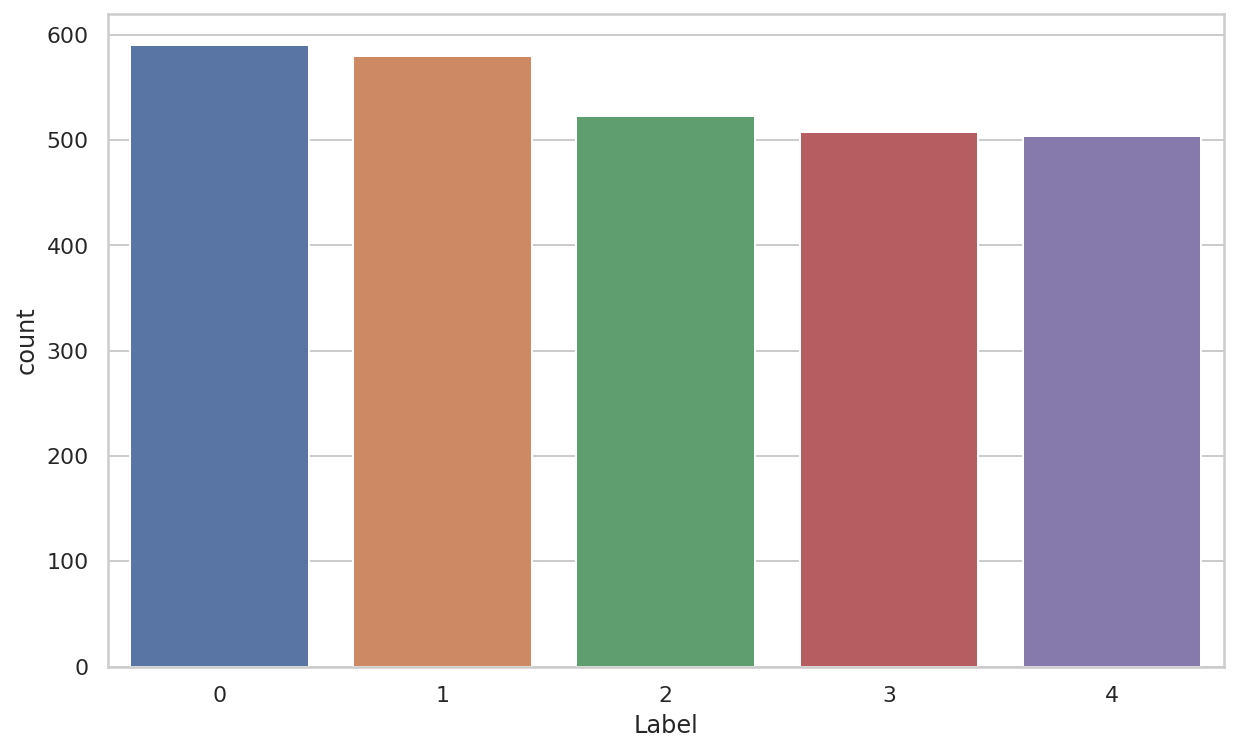

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(df_train['Label'])

## **BERT model for Portuguese**

### Let's tokenize the text to convert from raw text to numbers.

In [ ]:
pre_trained_BERTmodel='neuralmind/bert-base-portuguese-cased'

### Let's load a pre-trained BERT TokenizerFast:

In [ ]:
BERT_tokenizer=BertTokenizerFast.from_pretrained(pre_trained_BERTmodel, do_lower_case=False)

### **Choosing Sequence length for our dataset**

#### Let's store the token length of each message.

In [ ]:
token_lens=[]
for message in df_train['Inbound Message']:
  tokens_message=BERT_tokenizer.encode(message, max_length=150,truncation=True)
  token_lens.append(len(tokens_message))

Text(0.5, 0, 'Token count')

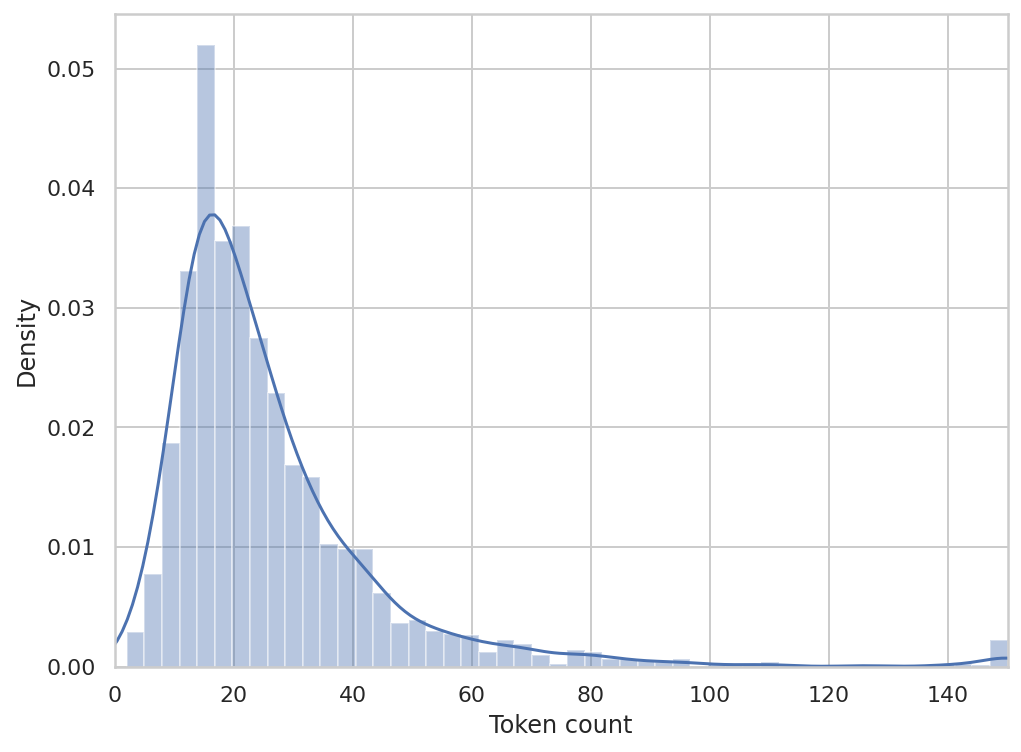

In [ ]:
#Plot the tokens
plt.figure(figsize=(8,6))
sns.distplot(token_lens)
plt.xlim([0,150])
plt.xlabel('Token count')

It appears that the length of most tokens lies between 0 & 100. On safer side, we are taking maximum sequence length of 150.

## Create a Pytorch Dataset

Pytorch dataset is of map-style i.e., it implements **getitem & len** protocols, & represents a map from indices/keys to datasamples.

In [ ]:
class message_Dataset(Dataset):

  def __init__(self, messages, targets, tokenizer, max_length):
    self.messages=messages
    self.targets=targets
    self.tokenizer=tokenizer
    self.max_length=max_length

  def __len__(self):
    return len(self.messages)

  def __getitem__(self,item):
    message = str(self.messages[item])
    targets = self.targets[item]

    encoding = self.tokenizer.encode_plus(
        message,
        max_length=Max_length,
        add_special_tokens=True,
        pad_to_max_length=True,
        truncation=True,
        return_attention_mask=True,
        return_token_type_ids=False,
        return_tensors='pt'
       )
           
    return {
        'message_text':message,
        'input_ids':encoding['input_ids'].flatten(),
        'attention_mask':encoding['attention_mask'].flatten(),
        'targets' : torch.tensor(targets,dtype=torch.long)
    }

Create a function for **Data loader**

In [ ]:
batch_size=8
Max_length= 150
def data_loader(df,tokenizer, max_length, batch):
  ds=message_Dataset(
      messages=df['Inbound Message'].to_numpy(),
      targets=df['Label'].to_numpy(),
      tokenizer=tokenizer,
      max_length=Max_length
  )

  return DataLoader(
      ds,
      batch_size=batch_size,
      num_workers=4
  )

# Load datasets
train_DataLoader=data_loader(df_train, BERT_tokenizer,Max_length,batch_size)
test_DataLoader=data_loader(df_test, BERT_tokenizer,Max_length,batch_size)
valid_DataLoader=data_loader(df_val, BERT_tokenizer,Max_length,batch_size)

#### Let's have a look at an example batch from **training DataLoader**

In [ ]:
BERT_data=next(iter(train_DataLoader))
BERT_data.keys()

dict_keys(['message_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
print('Shape of the BERT_data keys...')
print(f"Input_ids : {BERT_data['input_ids'].shape}")
print(f"Attention_mask : {BERT_data['attention_mask'].shape}")
print(f"targets : {BERT_data['targets'].shape}")

Shape of the BERT_data keys...
Input_ids : torch.Size([8, 150])
Attention_mask : torch.Size([8, 150])
targets : torch.Size([8])


Now move the batch training data to the GPU

In [ ]:
input_ids = BERT_data['input_ids'].to(device)
attention_mask = BERT_data['attention_mask'].to(device)
targets=BERT_data['targets'].to(device)
print(input_ids.shape)      # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([8, 150])
torch.Size([8, 150])


## Now build a Sentiment Classifier

[](http://)Let's load basic BERT model

In [ ]:
BERT_model = BertModel.from_pretrained(pre_trained_BERTmodel)
BERT_model=BERT_model.to(device)

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
n_classes=df['Label'].nunique()

Now create a classifier that uses BERT model

In [ ]:
class BERT_SentimentClassifier(nn.Module):
   def __init__(self, n_classes):
     super(BERT_SentimentClassifier, self).__init__()
     self.bert = BertModel.from_pretrained(pre_trained_BERTmodel)
     ### New layers:
     self.lstm = nn.LSTM(768, 256, batch_first=True,bidirectional=True)
     self.drop = nn.Dropout(p=float(0.6))
     self.linear = nn.Linear(256*2, n_classes)
     #self.drop1 = nn.Dropout(p=float(0.1))
     #self.hidden=nn.Linear(self.bert.config.hidden_size,256)
     #self.drop2 = nn.Dropout(p=float(0.1))
     #self.out = nn.Linear(256, n_classes)
   def forward(self, input_ids, attention_mask):
     sequence_output, pooled_output = self.bert(
         input_ids=input_ids,
         attention_mask=attention_mask,
         return_dict=False
    )
     # sequence_output has the following shape: (batch_size, sequence_length, 768)
     lstm_output, (h,c) = self.lstm(sequence_output) ## extract the 1st token's embeddings
     hidden = torch.cat((lstm_output[:,-1, :256],lstm_output[:,0, 256:]),dim=-1)
     output = self.drop(lstm_output)
     linear_output = self.linear(output[:,-1].view(-1,256*2)) ### We are only using the output of the last LSTM cell to perform classification

     #output = self.drop1(pooled_output)
     #output=self.hidden(output)
     #output = self.drop2(output)
     #output=self.out(output)
     return linear_output

The **pooled_output** is the summary of the tweet.
We are using a **dropout** layer for some regularization and a **LSTM** & a **fully-connected** layer for our output.

Let’s create an instance and move it to the GPU

In [ ]:
BERT_model = BERT_SentimentClassifier(n_classes)
BERT_model=BERT_model.to(device)

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Apply softmax function to the classifier output:

In [ ]:
F.softmax(BERT_model(input_ids,attention_mask), dim=1).to(device)

tensor([[0.1788, 0.2219, 0.2356, 0.1860, 0.1777],
        [0.2119, 0.2010, 0.1989, 0.1900, 0.1982],
        [0.1913, 0.2104, 0.2055, 0.2033, 0.1896],
        [0.1997, 0.1865, 0.2124, 0.1977, 0.2038],
        [0.2139, 0.1931, 0.1928, 0.2126, 0.1876],
        [0.2078, 0.2123, 0.2087, 0.2004, 0.1708],
        [0.1906, 0.2140, 0.2625, 0.1790, 0.1539],
        [0.2030, 0.2168, 0.2278, 0.1825, 0.1700]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)

In [ ]:
BERT_model

BERT_SentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

Let's train our BERT Sentiment classifier

We will use **AdamW** optimizer for correcting weight decay. We will also use, **linear scheduler** with no warm up steps:

In [ ]:
epochs=10
optimizer=AdamW(BERT_model.parameters(),lr=1e-5,correct_bias=False)
total_steps=len(train_DataLoader)*epochs

scheduler=get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn=nn.CrossEntropyLoss().to(device)

Now write a helper function to train our model:

In [ ]:
def train(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_observations
):
  model = model.train()
  losses = []
  correct_predictions = 0
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    #Feed data to BERT model
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
      )
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    torch.autograd.set_detect_anomaly(True)
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)     # Clip gradients to avoid exploding gradient problem
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double() / n_observations, np.mean(losses)

Similarly, write a function to evaluate our model:

In [ ]:
def eval_model(model, data_loader,device,loss_fn, n_observations):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      # Feed data to BERT model
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_observations, np.mean(losses)

Using above helper functions, write our training loop & store training history:

In [ ]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(epochs):
  print(f'Epoch {epoch + 1}/{epochs}')
  print('-' * 10)
  train_acc, train_loss = train(
    BERT_model,
    train_DataLoader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )
  print(f'Train loss {train_loss} accuracy {train_acc}')
  val_acc, val_loss = eval_model(
    BERT_model,
    valid_DataLoader,
    device,
    loss_fn,
    len(df_val)
  )
  print(f'Validation  loss {val_loss} accuracy {val_acc}')
  print()
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  if val_acc > best_accuracy:
    torch.save(BERT_model.state_dict(), 'best_BERT_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------
Train loss 1.1919472134922107 accuracy 0.5467652495378927
Validation  loss 0.8783936188664547 accuracy 0.6538461538461539

Epoch 2/10
----------
Train loss 0.7516423639646322 accuracy 0.7475046210720887
Validation  loss 0.863138016919757 accuracy 0.6715976331360947

Epoch 3/10
----------
Train loss 0.5409557266616891 accuracy 0.8340110905730129
Validation  loss 0.9176401239494945 accuracy 0.6923076923076923

Epoch 4/10
----------
Train loss 0.4202044420164068 accuracy 0.8813308687615526
Validation  loss 1.0239193687258765 accuracy 0.6952662721893491

Epoch 5/10
----------
Train loss 0.3474102205044664 accuracy 0.9116451016635859
Validation  loss 1.1753865091000186 accuracy 0.6923076923076923

Epoch 6/10
----------
Train loss 0.30409214224193826 accuracy 0.9249537892791128
Validation  loss 1.2830059855829838 accuracy 0.6982248520710059

Epoch 7/10
----------
Train loss 0.2801373699092056 accuracy 0.9286506469500924
Validation  loss 1.3150237231017199 accuracy 0.695

Let's look at **training vs validation accuracy**:

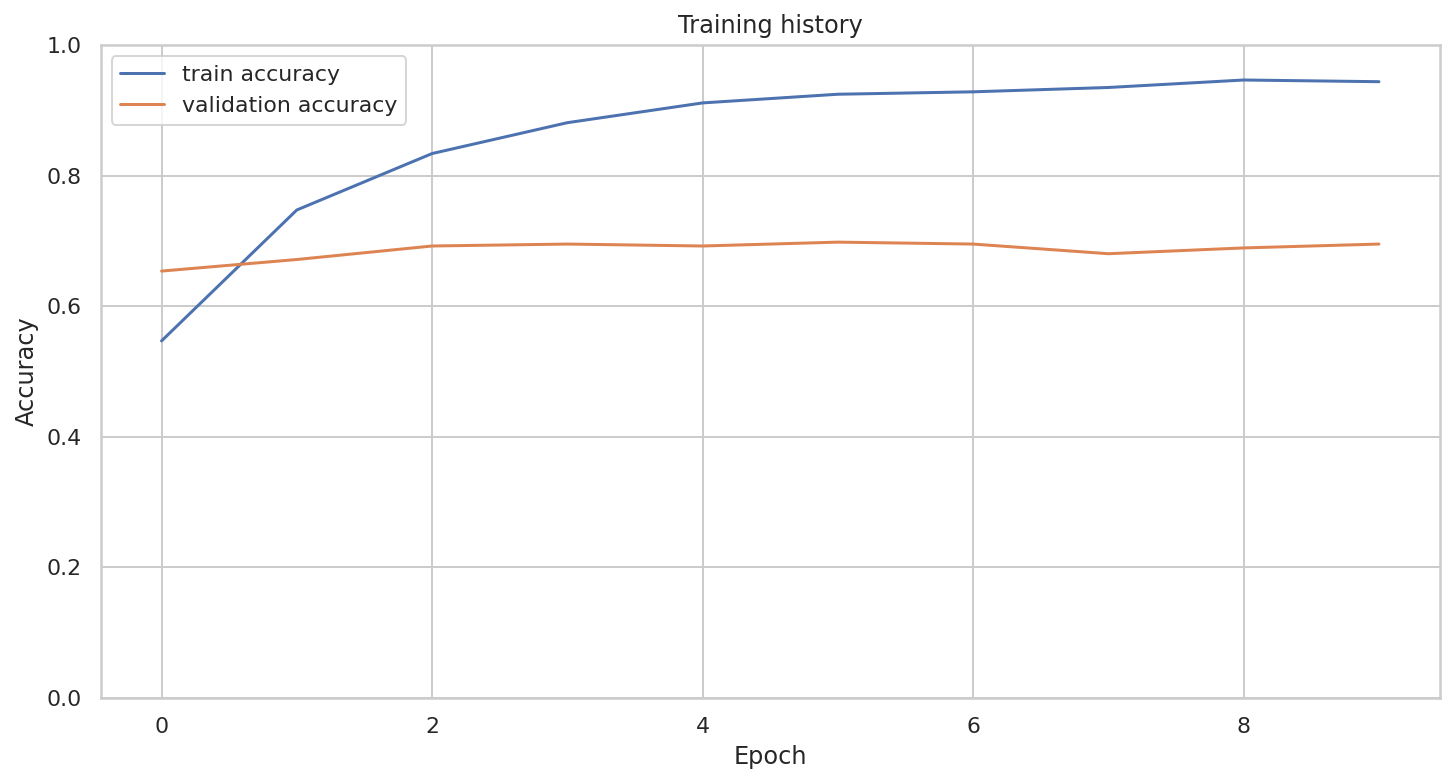

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

**Model Evaluation**

Let's see how good our model on unseen data.

Now we will write a function to get the predictions from our model:

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  messages = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:
      texts = d["message_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      messages.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return messages, predictions, prediction_probs, real_values

In [ ]:
messages, y_pred, y_pred_probs, y_test = get_predictions(
  BERT_model,
  test_DataLoader
)

Let's have a look at the classification report:

In [ ]:
class_report=classification_report(y_test, y_pred)
print(class_report)

              precision    recall  f1-score   support

           0       0.66      0.75      0.70        71
           1       0.68      0.62      0.64        78
           2       0.57      0.65      0.60        60
           3       0.87      0.84      0.86        57
           4       0.72      0.63      0.67        73

    accuracy                           0.69       339
   macro avg       0.70      0.70      0.70       339
weighted avg       0.70      0.69      0.69       339



Now will plot **confusion matrix**:

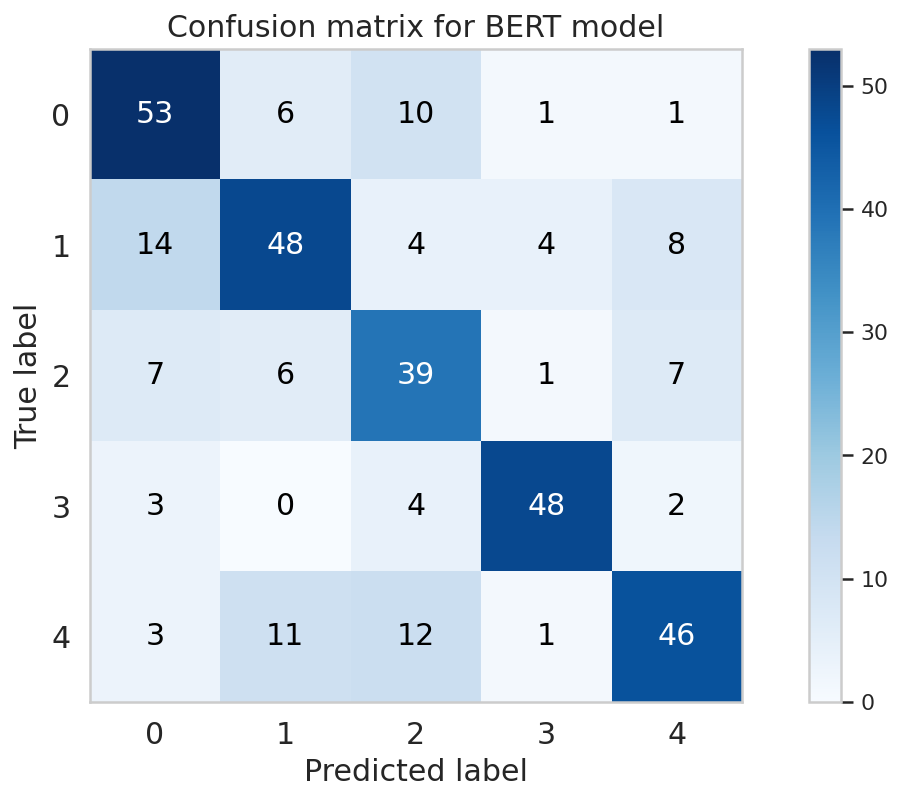

In [ ]:
#plot confusion matrix
plot_confusion_matrix(y_test, y_pred, title = 'Confusion matrix for BERT model', figsize = (12,6), \
                          text_fontsize = 15, title_fontsize = 15)

**Plot ROC curve**

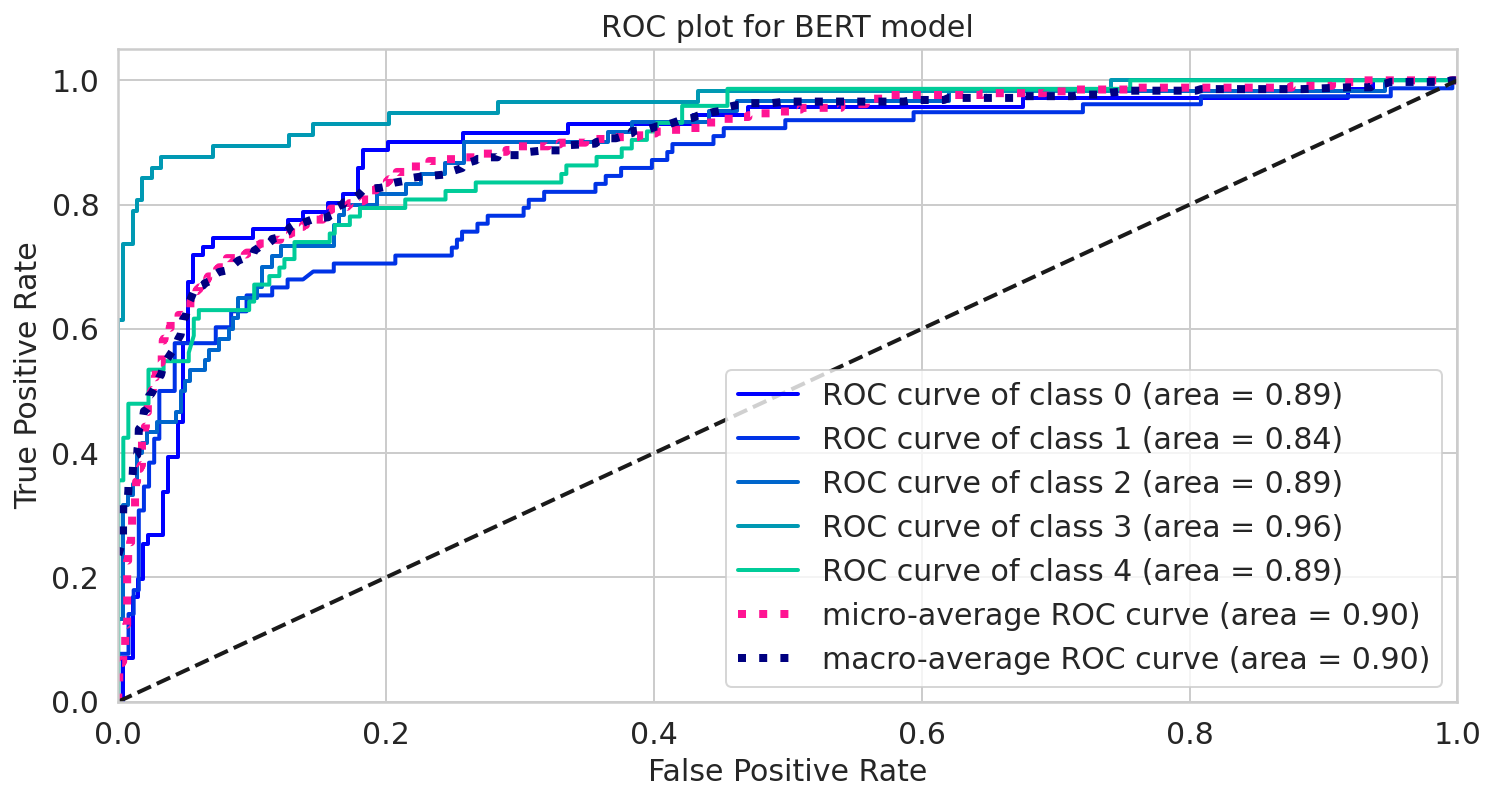

In [ ]:
# Plot ROC curve
plot_roc(y_test, y_pred_probs, figsize = (12,6), title = 'ROC plot for BERT model' ,text_fontsize = 15, title_fontsize = 15, cmap = 'winter')

In [ ]:
# Calculate precision, recall, f1_score, & roc_auc_score
from sklearn.metrics import precision_recall_fscore_support
precision_b, recall_b, f1_score_b, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
accuracy_b = accuracy_score(y_test, y_pred)
auc_score_b = roc_auc_score(y_test, F.softmax(y_pred_probs), average = 'weighted', multi_class='ovo')
print(f'Precision for BERT : {round(precision_b,2)}')
print(f'Recall for BERT : {round(recall_b,2)}')
print(f'F1_score for BERT : {round(f1_score_b,2)}')
print(f'AUC for BERT : {round(auc_score_b,2)}')
print(f'Accuracy score for BERT : {round(accuracy_b,2)}')

Precision for BERT : 0.7
Recall for BERT : 0.69
F1_score for BERT : 0.69
AUC for BERT : 0.9
Accuracy score for BERT : 0.69


## XLM-RoBERTa model for Binary classification

XLM-RoBERTa is a multilingual model trained on 100 different languages. Unlike some XLM multilingual models, it does not require lang tensors to understand which language is used, and should be able to determine the correct language from the input ids.     
For more details check,     
https://huggingface.co/transformers/model_doc/xlmroberta.html     
https://github.com/pytorch/fairseq/tree/master/examples/xlmr

In [ ]:
from transformers import XLMRobertaTokenizerFast, XLMRobertaModel

**XLM-RoBERTa model for Portuguese**

### Let's tokenize the text to convert from raw text to numbers.

In [ ]:
pre_trained_xlmrmodel='xlm-roberta-base'

### Let's load a pre-trained XLMRobertaTokenizerFast:

In [ ]:
XLM_tokenizer=XLMRobertaTokenizerFast.from_pretrained(pre_trained_xlmrmodel, do_lower_case=False)

### **Choosing Sequence length for our dataset**

#### Let's store the token length of each message.

In [ ]:
token_lens=[]
for message in df_train['Inbound Message']:
  tokens_message=XLM_tokenizer.encode(message, max_length=150,truncation=True)
  token_lens.append(len(tokens_message))

Text(0.5, 0, 'Token count')

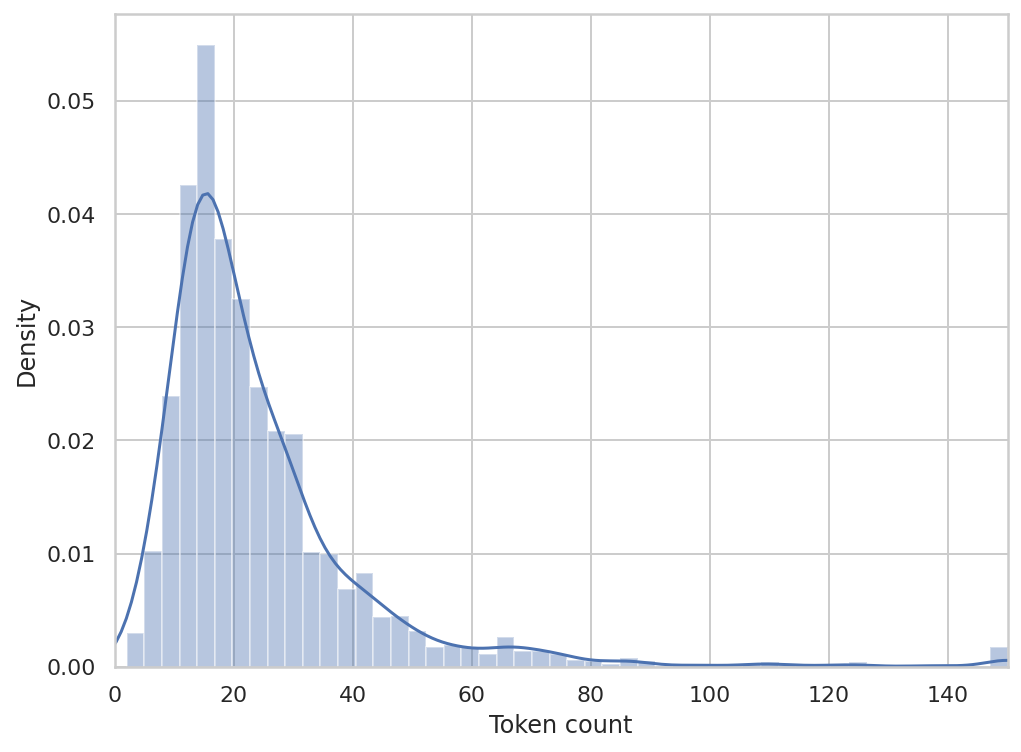

In [ ]:
#Plot the tokens
plt.figure(figsize=(8,6))
sns.distplot(token_lens)
plt.xlim([0,150])
plt.xlabel('Token count')

It appears that the length of most tokens lies between 0 & 100. On safer side, we are taking maximum sequence length of 150.

In [ ]:
# Load datasets in data loader
batch_size=8
Max_length= 150
train_DataLoader=data_loader(df_train, XLM_tokenizer,Max_length,batch_size)
test_DataLoader=data_loader(df_test, XLM_tokenizer,Max_length,batch_size)
valid_DataLoader=data_loader(df_val, XLM_tokenizer,Max_length,batch_size)

#### Let's have a look at an example batch from **training DataLoader**

In [ ]:
XLM_data=next(iter(train_DataLoader))
XLM_data.keys()

dict_keys(['message_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
print('Shape of the XLM_data keys...')
print(f"Input_ids : {XLM_data['input_ids'].shape}")
print(f"Attention_mask : {XLM_data['attention_mask'].shape}")
print(f"targets : {XLM_data['targets'].shape}")

Shape of the XLM_data keys...
Input_ids : torch.Size([8, 150])
Attention_mask : torch.Size([8, 150])
targets : torch.Size([8])


Now move the batch training data to the GPU.

In [ ]:
input_ids = XLM_data['input_ids'].to(device)
attention_mask = XLM_data['attention_mask'].to(device)
targets=XLM_data['targets'].to(device)
print(input_ids.shape)      # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([8, 150])
torch.Size([8, 150])


## Now build a Sentiment Classifier

Let's load basic XLM Roberta model:

In [ ]:
XLM_model = XLMRobertaModel.from_pretrained(pre_trained_xlmrmodel)
XLM_model=XLM_model.to(device)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Now create a classifier that uses XLM model.

In [ ]:
class XLM_SentimentClassifier(nn.Module):
   def __init__(self, n_classes):
     super(XLM_SentimentClassifier, self).__init__()
     self.xlmroberta = XLMRobertaModel.from_pretrained(pre_trained_xlmrmodel)
     ### New layers:
     self.lstm = nn.LSTM(768, 256, batch_first=True,bidirectional=True)
     self.drop = nn.Dropout(p=float(0.5))
     self.linear = nn.Linear(256*2, n_classes)
     #self.drop = nn.Dropout(p=float(0.5))
     #self.hidden=nn.Linear(self.xlmroberta.config.hidden_size, 512)
     #self.relu1 = nn.ReLU()
     #self.drop = nn.Dropout(p=float(0.2))
     #self.linear = nn.Linear(512, 256)
     #self.relu2 = nn.ReLU()
     #self.drop = nn.Dropout(p=float(0.05))
     #self.out = nn.Linear(256, n_classes)
   def forward(self, input_ids, attention_mask):
     sequence_output, pooled_output = self.xlmroberta(
         input_ids=input_ids,
         attention_mask=attention_mask,
         return_dict=False
    )
     # sequence_output has the following shape: (batch_size, sequence_length, 768)
     lstm_output, (h,c) = self.lstm(sequence_output) ## extract the 1st token's embeddings
     hidden = torch.cat((lstm_output[:,-1, :256],lstm_output[:,0, 256:]),dim=-1)
     output = self.drop(lstm_output)
     linear_output = self.linear(output[:,-1].view(-1,256*2)) ### We are only using the output of the last LSTM cell to perform classification

     #output = self.drop(pooled_output)
     #output = self.hidden(output)
     #output = self.relu1(output)
     #output = self.drop(output)
     #output = self.linear(output)
     #output = self.relu2(output)
     #output = self.drop(output)
     #output= self.out(linear_output)
     return linear_output

Let’s create an instance and move it to the GPU:

In [ ]:
XLM_model = XLM_SentimentClassifier(n_classes)
XLM_model=XLM_model.to(device)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Apply softmax function to the classifier output:

In [ ]:
F.softmax(XLM_model(input_ids,attention_mask), dim=1).to(device)

tensor([[0.2456, 0.2200, 0.1940, 0.1598, 0.1806],
        [0.1784, 0.2150, 0.2120, 0.1966, 0.1980],
        [0.1715, 0.2458, 0.2065, 0.1622, 0.2141],
        [0.1923, 0.1969, 0.2107, 0.2047, 0.1954],
        [0.1905, 0.2364, 0.2510, 0.1744, 0.1476],
        [0.2207, 0.2234, 0.2035, 0.1995, 0.1529],
        [0.2010, 0.2239, 0.1943, 0.2079, 0.1728],
        [0.2196, 0.2067, 0.1782, 0.1714, 0.2241]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)

In [ ]:
XLM_model

XLM_SentimentClassifier(
  (xlmroberta): XLMRobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNor

Let's train our XLM Sentiment classifier:

In [ ]:
epochs=5
optimizer=AdamW(XLM_model.parameters(),lr=1e-5, correct_bias=False)
total_steps=len(train_DataLoader)*epochs

scheduler=get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn=nn.CrossEntropyLoss().to(device)

Using above helper functions, write our training loop & store training history:

In [ ]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(epochs):
  print(f'Epoch {epoch + 1}/{epochs}')
  print('-' * 10)
  train_acc, train_loss = train(
    XLM_model,
    train_DataLoader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )
  print(f'Train loss {train_loss} accuracy {train_acc}')
  val_acc, val_loss = eval_model(
    XLM_model,
    valid_DataLoader,
    device,
    loss_fn,
    len(df_val)
  )
  print(f'Validation  loss {val_loss} accuracy {val_acc}')
  print()
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  if val_acc > best_accuracy:
    torch.save(XLM_model.state_dict(), 'best_XLM_model_state.bin')
    best_accuracy = val_acc

Epoch 1/5
----------


Let's look at training vs validation accuracy:

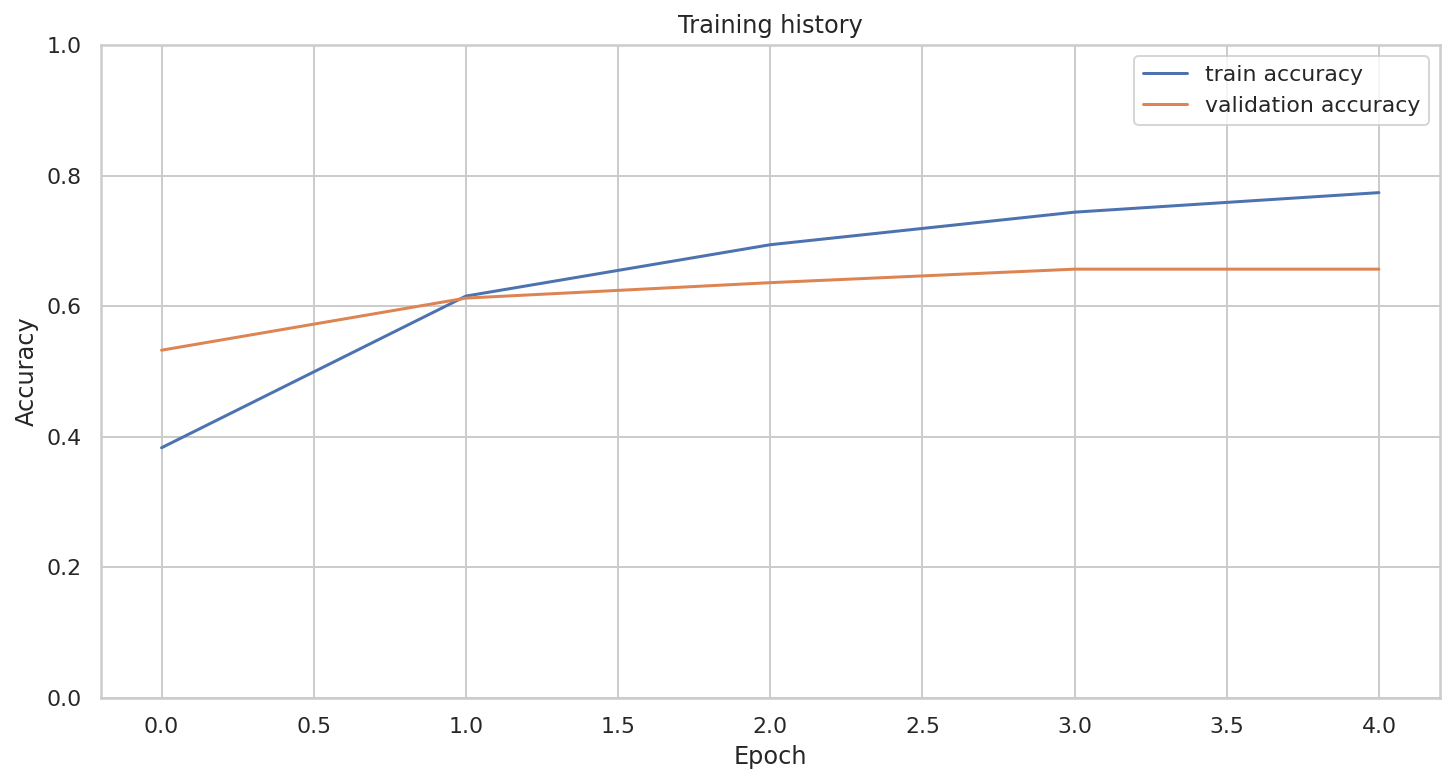

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

**Model Evaluation**

Let's see how good our model on unseen data.

Get the predictions from our model:

In [ ]:
messages, y_pred, y_pred_probs, y_test = get_predictions(
  XLM_model,
  test_DataLoader
)

Let's have a look at the classification report:

In [ ]:
class_report=classification_report(y_test, y_pred)
print(class_report)

              precision    recall  f1-score   support

           0       0.61      0.77      0.68        71
           1       0.66      0.65      0.66        78
           2       0.61      0.55      0.58        60
           3       0.84      0.74      0.79        57
           4       0.68      0.63      0.65        73

    accuracy                           0.67       339
   macro avg       0.68      0.67      0.67       339
weighted avg       0.68      0.67      0.67       339



Now will plot **confusion matrix**:

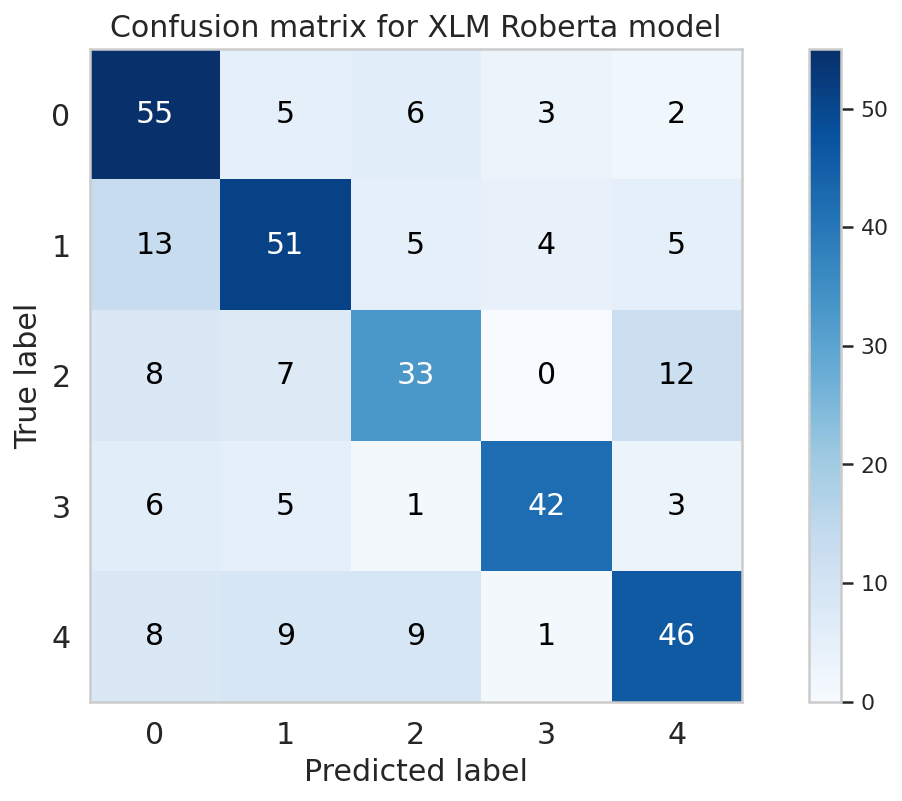

In [ ]:
#plot confusion matrix
plot_confusion_matrix(y_test, y_pred, title = 'Confusion matrix for XLM Roberta model', figsize = (12,6), \
                          text_fontsize = 15, title_fontsize = 15)

**Plot ROC curve**

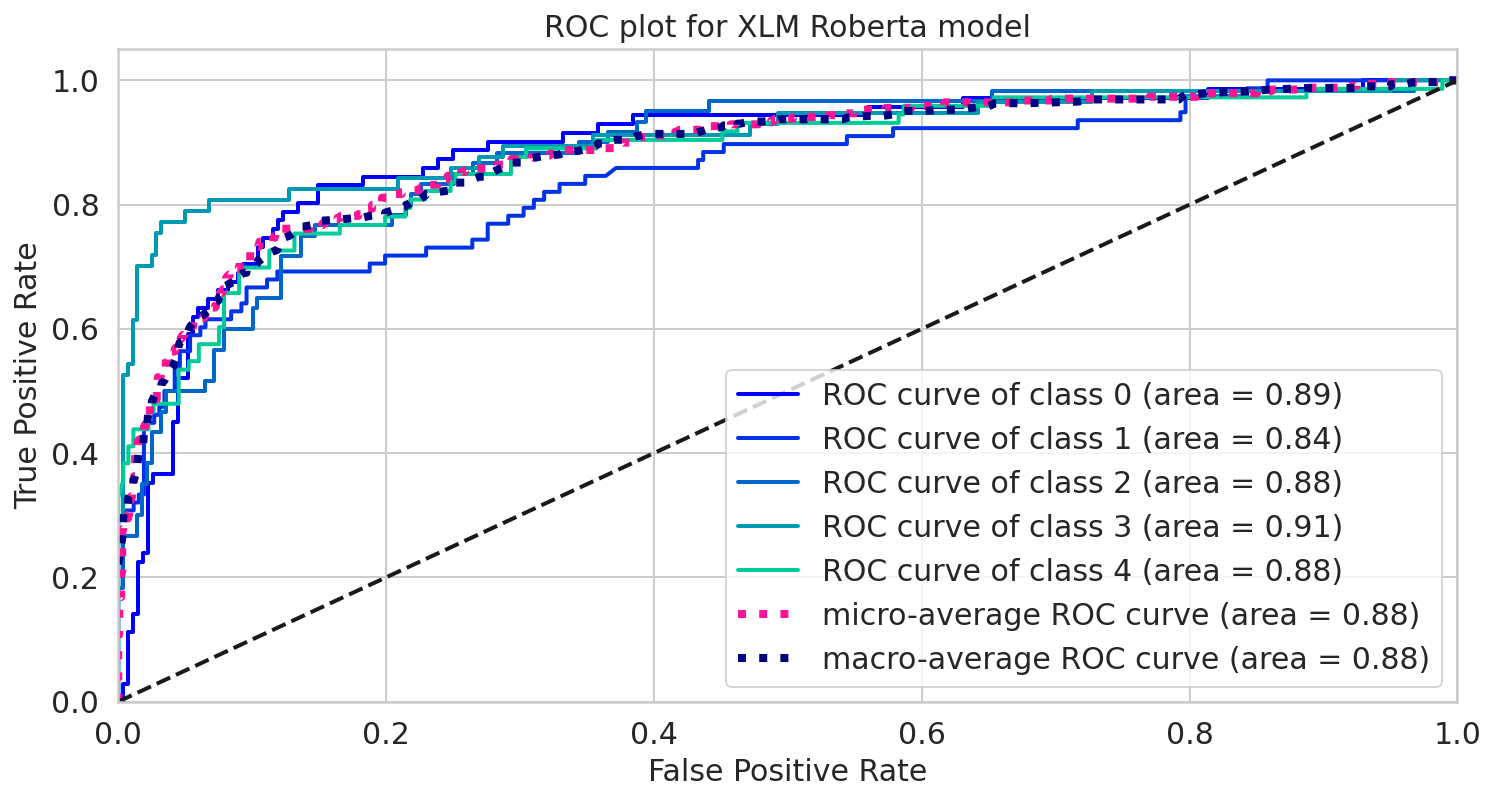

In [ ]:
# Plot ROC curve
plot_roc(y_test, y_pred_probs, figsize = (12,6), title = 'ROC plot for XLM Roberta model' ,text_fontsize = 15, title_fontsize = 15, cmap = 'winter')

In [ ]:
# Calculate precision, recall, f1_score, & roc_auc_score
precision_xlm, recall_xlm, f1_score_xlm, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
accuracy_xlm = accuracy_score(y_test, y_pred)
auc_score_xlm = roc_auc_score(y_test, F.softmax(y_pred_probs), average = 'weighted', multi_class='ovo')
print(f'Precision for XLM Roberta : {round(precision_xlm,2)}')
print(f'Recall for XLM Roberta : {round(recall_xlm,2)}')
print(f'F1_score for XLM Roberta : {round(f1_score_xlm,2)}')
print(f'AUC score for XLM Roberta : {round(auc_score_xlm,2)}')
print(f'Accuracy score for XLM Roberta : {round(accuracy_xlm,2)}')

Precision for XLM Roberta : 0.68
Recall for XLM Roberta : 0.67
F1_score for XLM Roberta : 0.67
AUC score for XLM Roberta : 0.89
Accuracy score for XLM Roberta : 0.67


### Comparision of models

In [ ]:
Results={
    'Model':['BERT','XLM-RoBERTa'],
    'Accuracy':[accuracy_b, accuracy_xlm],
    'Precision':[precision_b, precision_xlm],
    'Recall' : [recall_b, recall_xlm],
    'f1-score(weighted)':[f1_score_b, f1_score_xlm],
    'AUC':[auc_score_b, auc_score_xlm],
}

results_df=pd.DataFrame(Results)
# Sort_values by AUC
results_df = results_df.sort_values(by = ['AUC'], ascending=False).reset_index(drop = True)
results_df = results_df.round(2)
results_df.index+=1
results_df

,Model,Accuracy,Precision,Recall,f1-score(weighted),AUC
1,BERT,0.88,0.88,0.88,0.88,0.95
2,XLM-RoBERTa,0.88,0.88,0.88,0.87,0.94
